In [1]:
from datetime import datetime
from pathlib import Path
import os

import click
import torch
import wandb
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
import logging
import lightning as L
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from transformers import EsmForMaskedLM, AutoTokenizer


from egfr_binder_rd2.datamodule import SequenceDataModule
from egfr_binder_rd2.bt import BTRegressionModule
from egfr_binder_rd2.binding_dataset import get_dataset


%load_ext autoreload
%autoreload 2

torch.set_float32_matmul_precision('medium')

seed = 42
debug = True


/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_logging(debug: bool):
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logger = logging.getLogger(__name__)
    logger.info("Logging setup complete.")
    return logger

In [3]:
yvar = 'Average_i_pAE'
# yvar = 'Average_i_pTM'
yvar = 'Average_pLDDT'
yvar = 'encoded_expression'

In [ ]:
fp = '/home/naka/code/BindCraft/outputs/EGFR_single_domain/mpnn_design_stats.csv'
df = pd.read_csv(fp)


In [ ]:
fp = 'https://raw.githubusercontent.com/adaptyvbio/egfr_competition_1/refs/heads/main/results/replicate_summary.csv'
seqs = pd.read_csv('https://raw.githubusercontent.com/adaptyvbio/egfr_competition_1/refs/heads/main/results/result_summary.csv')
df = pd.read_csv(fp).merge(seqs[['name', 'sequence']])

In [ ]:
expression_map = {'low': 1, 'medium': 2, 'high': 3, 'none': 0}
df['encoded_expression'] = df['nc_adjusted_expression'].map(expression_map)

In [ ]:
df = df.groupby(['name', 'sequence']).agg({'encoded_expression': 'mean'}).reset_index()

In [3]:
df.dropna(subset=[yvar])

NameError: name 'df' is not defined

In [3]:
df = get_dataset()
yvar = 'pae_interaction'
xvar = 'binder_sequence'

In [4]:

# Create and setup the DataModule
data_module = SequenceDataModule(
    df, 
    tokenizer_name="facebook/esm2_t33_650M_UR50D",
    xvar=xvar,
    yvar=yvar,  # You can change this to any other column name in your DataFrame
    batch_size=8,
    max_length=512,
    transform_type='rank',
    make_negative=True,
)
data_module.setup()



Map: 100%|██████████| 177/177 [00:00<00:00, 2646.39 examples/s]
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 177/177 [00:00<00:00, 3412.29 examples/s]


In [5]:

# 3. Create the model
model = BTRegressionModule(
    label=yvar,
    # model_name="facebook/esm2_t33_650M_UR50D",
    # model_name="facebook/esm2_t30_150M_UR50D",
    # model_name='facebook/esm2_t12_35M_UR50D',
    model_name='facebook/esm2_t6_8M_UR50D',
    lr=3e-4,
    peft_r=8,
    peft_alpha=16,
    max_length=512,
)

# 4. Set up callbacks
early_stop_callback = EarlyStopping(
    monitor='val_spearman',
    min_delta=0.00,
    patience=30,
    verbose=False,
    mode='max'
)

# 5. Set up wandb logger
wandb_logger = WandbLogger(project="bt_regression")

# 6. Create the trainer
trainer = L.Trainer(
    max_epochs=3,
    callbacks=[early_stop_callback],
    logger=wandb_logger,
    accelerator='gpu',
    devices=1,  # Use 1 GPU
    log_every_n_steps=10,
    enable_checkpointing=False,  # Disable checkpoint saving
    val_check_interval=0.25,  # Check validation 4 times per epoch
)


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/naka/code/egfr_binder_

In [6]:

# 7. Train the model
trainer.fit(model, data_module)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anaka (anaka_personal). Use `wandb login --relogin` to force relogin


Map: 100%|██████████| 177/177 [00:00<00:00, 2797.16 examples/s]
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 177/177 [00:00<00:00, 3380.22 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                               | Params | Mode 
-----------------------------------------------------------------------------
0 | esm_model     | PeftModelForSequenceClassification | 8.0 M  | train
1 | bt_loss       | BradleyTerryLoss                   | 0      | train
2 | train_metrics | MetricCollection                   | 0      | train
3 | val_mae       | MeanAbsoluteError                  | 0      | train
4 | val_spearman  | SpearmanCorrCoef                   | 0      | train
---------

Epoch 2: 100%|██████████| 80/80 [00:04<00:00, 18.52it/s, v_num=lrub]       

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 80/80 [00:04<00:00, 18.52it/s, v_num=lrub]


In [7]:
from egfr_binder_rd2.utils import hash_seq

In [ ]:
train_preds = trainer.predict(model, data_module.train_dataloader(shuffle=False))
val_preds = trainer.predict(model, data_module.val_dataloader())
test_preds = trainer.predict(model, data_module.test_dataloader())



In [21]:

# Convert predictions and sequences to lists
def create_pred_df(predictions_list, name=""):
    try:
        # Validate predictions
        if not predictions_list or any(x is None for x in predictions_list):
            raise ValueError(f"Empty or None predictions in {name} set")
            
        # Validate prediction tensors and sequences
        pred_tensors = []
        sequences = []
        for batch in predictions_list:
            if 'predictions' not in batch or 'sequence' not in batch:
                raise ValueError(f"Missing predictions or sequence in {name} batch")
                
            pred_tensor = batch['predictions'].view(-1, 1)
            if not torch.is_tensor(pred_tensor) or pred_tensor.numel() == 0:
                raise ValueError(f"Invalid prediction tensor in {name} batch")
                
            pred_tensors.append(pred_tensor)
            sequences.extend(batch['sequence'])
        
        # Validate sequences are strings
        if not all(isinstance(seq, str) for seq in sequences):
            raise ValueError(f"Non-string sequences found in {name} set")
            
        # Create dataframe
        df = pd.DataFrame({
            'predictions': torch.cat(pred_tensors).cpu().numpy().squeeze(),
            'sequence': sequences,
        })
        
        # Add hash column only if sequences are valid
        df['hash'] = df['sequence'].apply(lambda x: hash_seq(x) if isinstance(x, str) else None)
        
        return df
        
    except Exception as e:
        raise e

# Convert predictions and sequences to dataframes
train_df = create_pred_df(train_preds, "train") 
val_df = create_pred_df(val_preds, "validation")
test_df = create_pred_df(test_preds, "test")

# Add sequence info and other metrics
train_df[yvar] = data_module.train_dataset[yvar].numpy()
val_df[yvar] = data_module.val_dataset[yvar].numpy()
test_df[yvar] = data_module.test_dataset[yvar].numpy()

# Add additional metrics
for df, split_name in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
    df['pred_rank'] = df['predictions'].rank()
    df['true_rank'] = df[yvar].rank()
    df['residuals'] = df[yvar] - df['predictions']
    df['split'] = split_name
    df['length'] = df['sequence'].str.len()
    df['hash'] = df['sequence'].apply(hash_seq)


NameError: name 'train_actual' is not defined

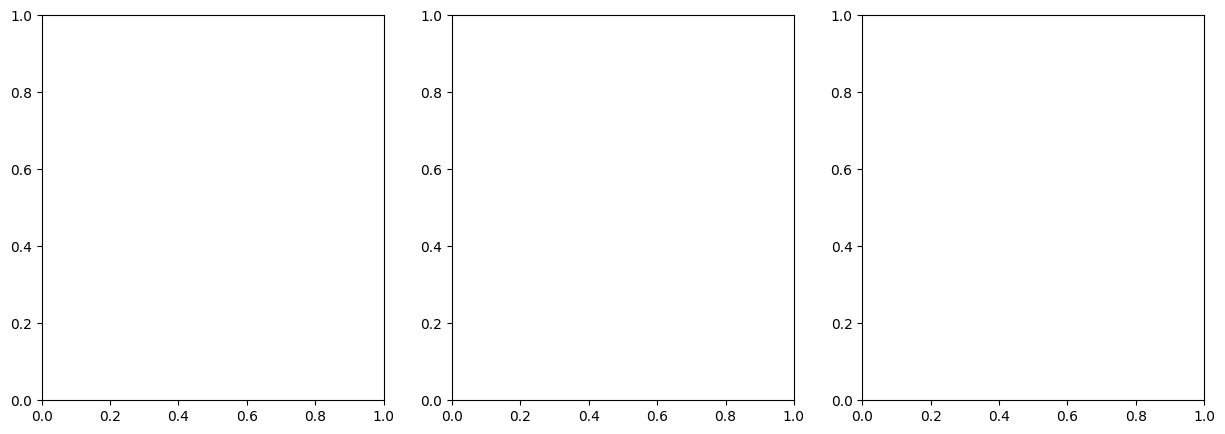

In [22]:

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot training data
sns.scatterplot(x=train_actual, y=train_preds, ax=ax1)
ax1.set_title('Training Set')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')

# Plot validation data
sns.scatterplot(x=val_actual, y=val_preds, ax=ax2)
ax2.set_title('Validation Set')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')

# Plot test data
sns.scatterplot(x=test_actual, y=test_preds, ax=ax3)
ax3.set_title('Test Set')
ax3.set_xlabel('Actual')
ax3.set_ylabel('Predicted')

# Add correlation coefficients to titles
train_corr = spearmanr(train_actual, train_preds)[0]
val_corr = spearmanr(val_actual, val_preds)[0]
test_corr = spearmanr(test_actual, test_preds)[0]

ax1.set_title(f'Training Set\nSpearman ρ={train_corr:.3f}')
ax2.set_title(f'Validation Set\nSpearman ρ={val_corr:.3f}')
ax3.set_title(f'Test Set\nSpearman ρ={test_corr:.3f}')

plt.tight_layout()
plt.show()

In [15]:
from egfr_binder_rd2.esm_regression_expert import EsmRegressionExpert
import evo_prot_grad
from tqdm import tqdm

In [30]:
i_pae_expert = EsmRegressionExpert(
    temperature=1.0,
    model=model,
    tokenizer=model.tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

In [48]:
esm_expert = evo_prot_grad.get_expert(
    expert_name='esm',
    scoring_strategy="mutant_marginal",
    model = EsmForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D"),
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D"),
    device="cuda" if torch.cuda.is_available() else "cpu",
)

In [70]:
experts = [esm_expert, i_pae_expert]

In [83]:
sequence = df.iloc[0]['binder_sequence'] + 'ELR'

In [97]:
sequence = 'AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQDVEELRKRAEEMVEEYEKSS'

In [98]:
serial_chains = 4
n_steps = 250
max_mutations = 5
verbose=False
n_parallel_chains = 4
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

results = []
total_chains = 0

for _ in tqdm(range(serial_chains)):
    variants, scores = evo_prot_grad.DirectedEvolution(
        wt_protein=sequence,
        output="all",
        experts=experts,
        parallel_chains=n_parallel_chains,
        n_steps=n_steps,
        max_mutations=max_mutations,
        verbose=verbose,
        # preserved_regions=[(103, 104), (208, 209), (212, 213)],
    )()
    for chain in range(scores.shape[1]):
        for step in range(scores.shape[0]):
            seq = "".join(variants[step][chain].split(" "))
            score = scores[step, chain]
            results.append(
                {
                    "run": timestamp,
                    "chain": total_chains,
                    "step": step,
                    "score": score,
                    "sequence": seq,
                }
            )
        total_chains += 1

100%|██████████| 4/4 [01:23<00:00, 20.98s/it]


In [108]:
score

20.587156

In [109]:
sampled = pd.DataFrame(results)
sampled = sampled.drop_duplicates(subset=['sequence'])

In [110]:
sampled

,run,chain,step,score,sequence
0,20241030-234716,0,0,2.686405,AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
1,20241030-234716,0,1,9.457047,AETMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
2,20241030-234716,0,2,13.343776,AETMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
3,20241030-234716,0,3,13.343776,MEVMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQD...
4,20241030-234716,0,4,9.660851,MEVMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQD...
...,...,...,...,...,...
3995,20241030-234716,15,245,16.913095,MERMRRRFEHIVEIVEEWAKEVLENEKKQGSKEEDLKFMEEYLEAD...
3996,20241030-234716,15,246,16.913095,AERMRRRFEHIVEIREEWAKEVLENLKKQGSKEEDLKFMEEYLEHD...
3997,20241030-234716,15,247,13.506359,AERMRRRFEHIVEEREEWAKEVLENLKKQGSKEEDLKFMEEYLEHD...
3998,20241030-234716,15,248,20.587156,KERMRRRFEHIVEEREEWAKEVLENLKKQGSKEEDLKHMEEYLEHD...


In [116]:
sequences = sampled.sort_values('score', ascending=False).head(300).sample(64)['sequence'].to_list()

In [131]:
import modal

get_msa = modal.Function.lookup("simplefold", 'get_msa_for_binder')
a3m_from_template = modal.Function.lookup("simplefold", 'a3m_from_template')
fold_binder = modal.Function.lookup("simplefold", 'fold_binder')
update_metrics = modal.Function.lookup("simplefold", 'update_metrics_for_all_folded')
esm2_pll = modal.Function.lookup("esm2-inference", 'process_sequences')
update_pll_metrics = modal.Function.lookup("esm2-inference", 'update_pll_metrics')

In [ ]:
fold_binder.remote(binder_seqs=[sequence])

In [133]:
get_msa.remote(binder_seqs=[sequence], )

[PosixPath('/colabfold_data/msa_results/f9aee7.a3m')]

In [129]:
from egfr_binder_rd2 import EGFR
from egfr_binder_rd2.utils import hash_seq

In [135]:
df = update_metrics.remote()

In [134]:
fold_binder.remote(binder_seqs=sequences, parent_binder_seqs=sequence)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]